
# Decision Tree Classification Project: Air Quality Dataset

This project involves building and analyzing Decision Tree classifiers on the **Air Quality** dataset from the UCI Machine Learning Repository.

## Objectives
1. Preprocess the dataset to handle missing values, encode categorical variables, and normalize numerical features.
2. Train Decision Tree models using different splitting methods:
   - Information Gain
   - Gini Index
   - Reduction in Variance
   - Chi-Square
3. Compare and analyze the performance of these models.
4. Visualize the decision trees and interpret the results.
5. Document findings, strengths, and weaknesses of each splitting method.


In [18]:
pip install pandas numpy scikit-learn matplotlib ucimlrepo


In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator

# Fetch dataset
air_quality = fetch_ucirepo(id=360)

# Data (features and targets)
X = air_quality.data.features
y = air_quality.data.targets

# Metadata
print("Dataset Metadata:")
print(air_quality.metadata)


Dataset Metadata:
{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'ID': 420, 'type': 'NATIVE', 'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scen

In [34]:
# Create a synthetic target variable (e.g., based on pollution levels)
y = (X['CO(GT)'] > X['CO(GT)'].mean()).astype(int)
X = X.drop(columns=['CO(GT)'])  # Drop the column used for the target


In [35]:
print(X)

           Date      Time  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
0     3/10/2004  18:00:00         1360       150      11.9           1046   
1     3/10/2004  19:00:00         1292       112       9.4            955   
2     3/10/2004  20:00:00         1402        88       9.0            939   
3     3/10/2004  21:00:00         1376        80       9.2            948   
4     3/10/2004  22:00:00         1272        51       6.5            836   
...         ...       ...          ...       ...       ...            ...   
9352   4/4/2005  10:00:00         1314      -200      13.5           1101   
9353   4/4/2005  11:00:00         1163      -200      11.4           1027   
9354   4/4/2005  12:00:00         1142      -200      12.4           1063   
9355   4/4/2005  13:00:00         1003      -200       9.5            961   
9356   4/4/2005  14:00:00         1071      -200      11.9           1047   

      NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH

In [36]:
print(y)

0       1
1       1
2       1
3       1
4       1
       ..
9352    1
9353    1
9354    1
9355    1
9356    1
Name: CO(GT), Length: 9357, dtype: int64


## Data Preprocessing

In [37]:
# Inspect the data
print("First few rows of the features:")
print(X.head())

print("First few rows of the target variable:")
print(y.head())

# Drop 'Date' and 'Time' columns as they are not useful for classification
X = X.drop(columns=['Date', 'Time'])

# Check for missing values
print("Missing values in the dataset:")
print(X.isnull().sum())



First few rows of the features:
        Date      Time  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
0  3/10/2004  18:00:00         1360       150      11.9           1046   
1  3/10/2004  19:00:00         1292       112       9.4            955   
2  3/10/2004  20:00:00         1402        88       9.0            939   
3  3/10/2004  21:00:00         1376        80       9.2            948   
4  3/10/2004  22:00:00         1272        51       6.5            836   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0      166          1056      113          1692         1268  13.6  48.9   
1      103          1174       92          1559          972  13.3  47.7   
2      131          1140      114          1555         1074  11.9  54.0   
3      172          1092      122          1584         1203  11.0  60.0   
4      131          1205      116          1490         1110  11.2  59.6   

       AH  
0  0.7578  
1  0.7255  
2  0.7502  
3  0.7867  
4  0.7

In [38]:
# Handle missing values (if any)
X.fillna(X.mean(), inplace=True)

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Preprocessing: One-Hot Encode categorical variables, Standardize numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)])

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Model Implementation

In [45]:
class ChiSquareDecisionTree(BaseEstimator):
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)
        return self

    def _build_tree(self, X, y, depth=0):
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return {'label': np.unique(y)[0]}  # Leaf node

        best_feature, best_value = self._find_best_split(X, y)
        if best_feature is None:
            return {'label': np.unique(y)[0]}

        left_mask = X[:, best_feature] <= best_value
        right_mask = ~left_mask
        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {'feature': best_feature, 'value': best_value, 'left': left_tree, 'right': right_tree}

    def _find_best_split(self, X, y):
        best_chi2 = 0
        best_feature = None
        best_value = None

        for feature in range(X.shape[1]):
            feature_values = np.unique(X[:, feature])
            for value in feature_values:
                left_mask = X[:, feature] <= value
                right_mask = ~left_mask
                contingency_table = self._create_contingency_table(y[left_mask], y[right_mask])
                if contingency_table.size == 0:  # If table is empty, skip
                    continue
                chi2, p_value, _, _ = chi2_contingency(contingency_table)
                if chi2 > best_chi2:
                    best_chi2 = chi2
                    best_feature = feature
                    best_value = value

        return best_feature, best_value

    def _create_contingency_table(self, left_y, right_y):
        # Count the occurrences of each class in the left and right splits
        left_counts = np.bincount(left_y)
        right_counts = np.bincount(right_y)

        # Ensure the contingency table has the same number of classes
        max_class = max(len(left_counts), len(right_counts))
        left_counts = np.pad(left_counts, (0, max_class - len(left_counts)), 'constant')
        right_counts = np.pad(right_counts, (0, max_class - len(right_counts)), 'constant')

        table = np.array([left_counts, right_counts])
        # Check if the contingency table is empty
        if np.any(table == 0):
            return np.array([])
        return table

    def predict(self, X):
        return np.array([self._predict_row(row, self.tree) for row in X])

    def _predict_row(self, row, tree):
        if 'label' in tree:
            return tree['label']

        feature_value = row[tree['feature']]
        if feature_value <= tree['value']:
            return self._predict_row(row, tree['left'])
        else:
            return self._predict_row(row, tree['right'])


In [46]:
class VarianceReductionDecisionTree(BaseEstimator):
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)
        return self

    def _build_tree(self, X, y, depth=0):
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return {'label': np.unique(y)[0]}  # Leaf node

        best_feature, best_value = self._find_best_split(X, y)
        if best_feature is None:
            return {'label': np.unique(y)[0]}

        left_mask = X[:, best_feature] <= best_value
        right_mask = ~left_mask
        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {'feature': best_feature, 'value': best_value, 'left': left_tree, 'right': right_tree}

    def _find_best_split(self, X, y):
        best_variance_reduction = 0
        best_feature = None
        best_value = None

        for feature in range(X.shape[1]):
            feature_values = np.unique(X[:, feature])
            for value in feature_values:
                left_mask = X[:, feature] <= value
                right_mask = ~left_mask
                left_variance = np.var(y[left_mask])
                right_variance = np.var(y[right_mask])
                total_variance = np.var(y)
                variance_reduction = total_variance - (left_variance * len(left_mask) + right_variance * len(right_mask)) / len(y)

                if variance_reduction > best_variance_reduction:
                    best_variance_reduction = variance_reduction
                    best_feature = feature
                    best_value = value

        return best_feature, best_value

    def predict(self, X):
        return np.array([self._predict_row(row, self.tree) for row in X])

    def _predict_row(self, row, tree):
        if 'label' in tree:
            return tree['label']

        feature_value = row[tree['feature']]
        if feature_value <= tree['value']:
            return self._predict_row(row, tree['left'])
        else:
            return self._predict_row(row, tree['right'])


In [50]:
# Train Decision Tree models using different splitting criteria
criteria = ['gini', 'entropy', 'chi2', 'variance']  # Gini Index, Information Gain, Chi-Square, Variance Reduction
results = {}

# Dictionary to store models for visualization
models = {}

for criterion in criteria:
    print(f"\nTraining Decision Tree with {criterion} criterion...")

    # Create pipeline for the Decision Tree
    if criterion == 'chi2':
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', ChiSquareDecisionTree(max_depth=5))])
    elif criterion == 'variance':
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', VarianceReductionDecisionTree(max_depth=5))])
    else:
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(criterion=criterion, random_state=42))])

    # Train the model
    clf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[criterion] = accuracy
    models[criterion] = clf.named_steps['classifier']
    print(f"Accuracy with {criterion}: {accuracy:.2f}")

# Display results
print("\nModel Accuracy for Different Splitting Criteria:")
for criterion, accuracy in results.items():
    print(f"{criterion.capitalize()}: {accuracy:.2f}")


Training Decision Tree with gini criterion...
Accuracy with gini: 0.89

Training Decision Tree with entropy criterion...
Accuracy with entropy: 0.90

Training Decision Tree with chi2 criterion...
Accuracy with chi2: 0.17

Training Decision Tree with variance criterion...
Accuracy with variance: 0.17

Model Accuracy for Different Splitting Criteria:
Gini: 0.89
Entropy: 0.90
Chi2: 0.17
Variance: 0.17


## Analysis and Visualization

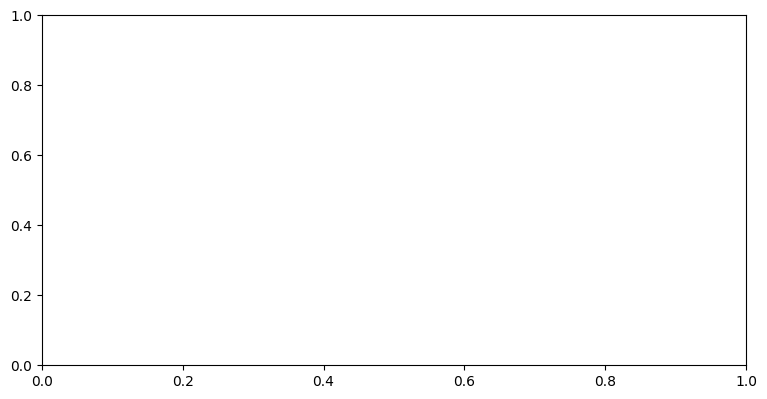

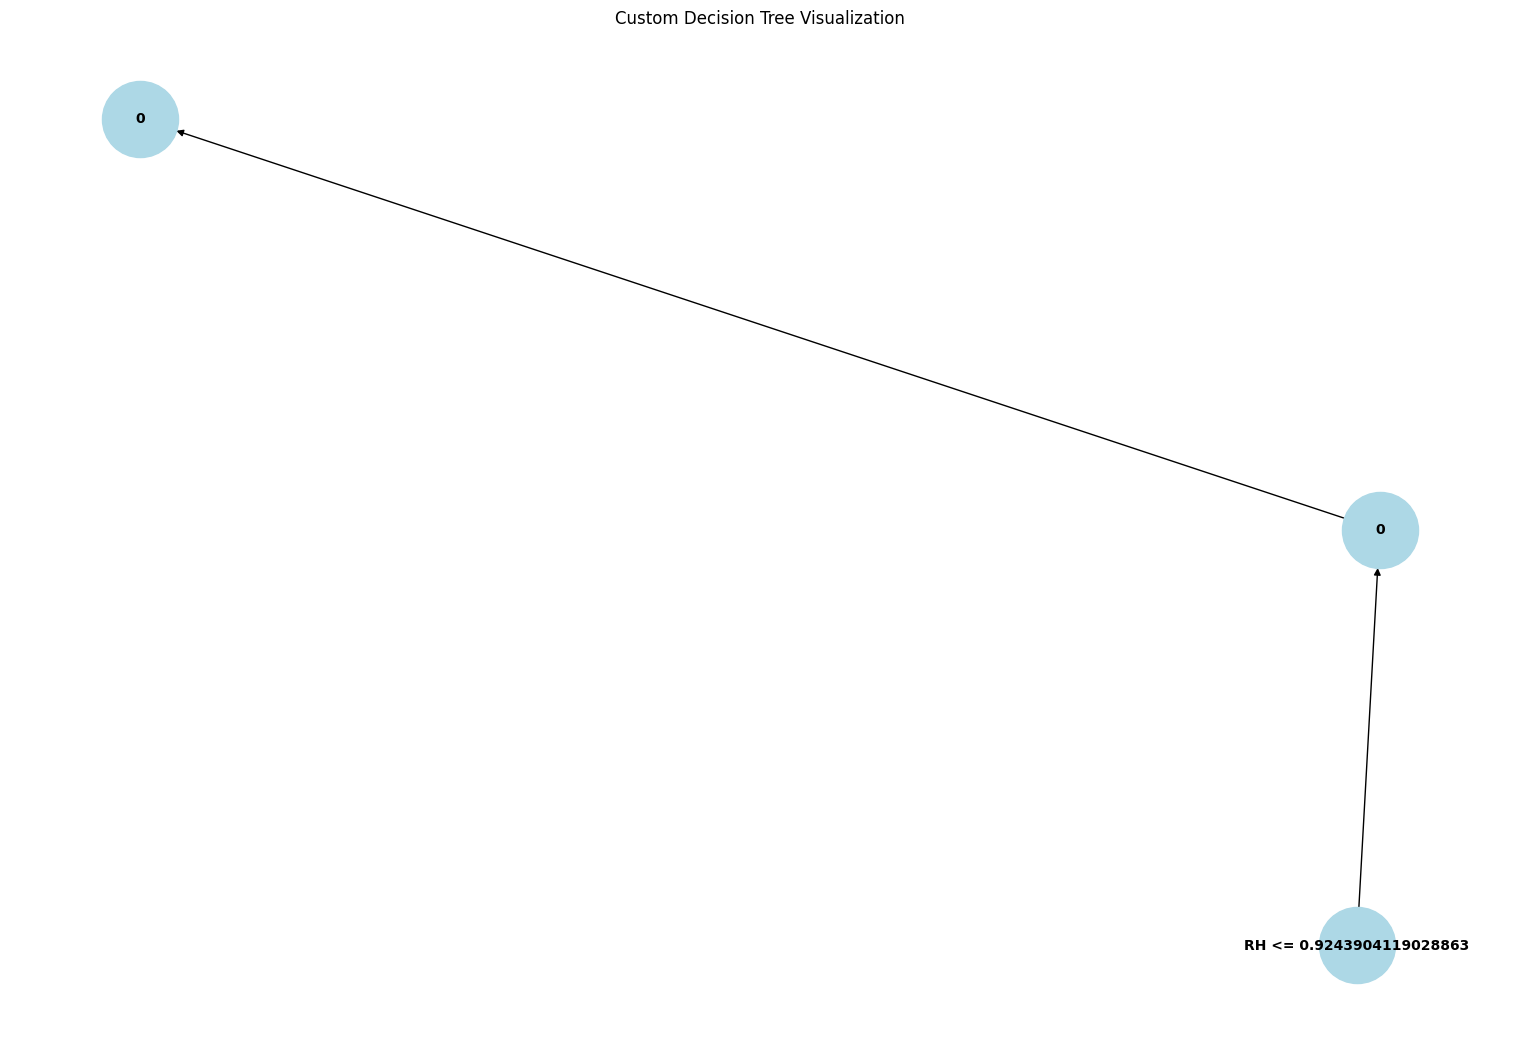

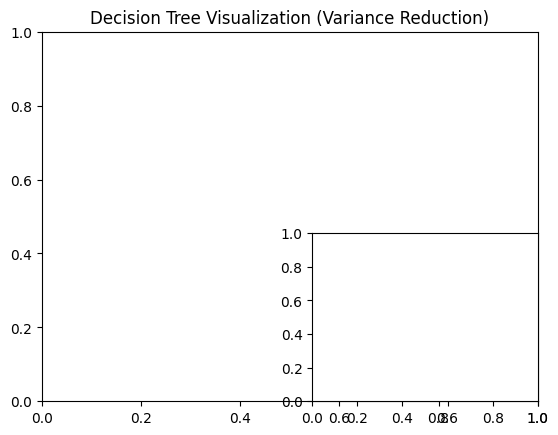

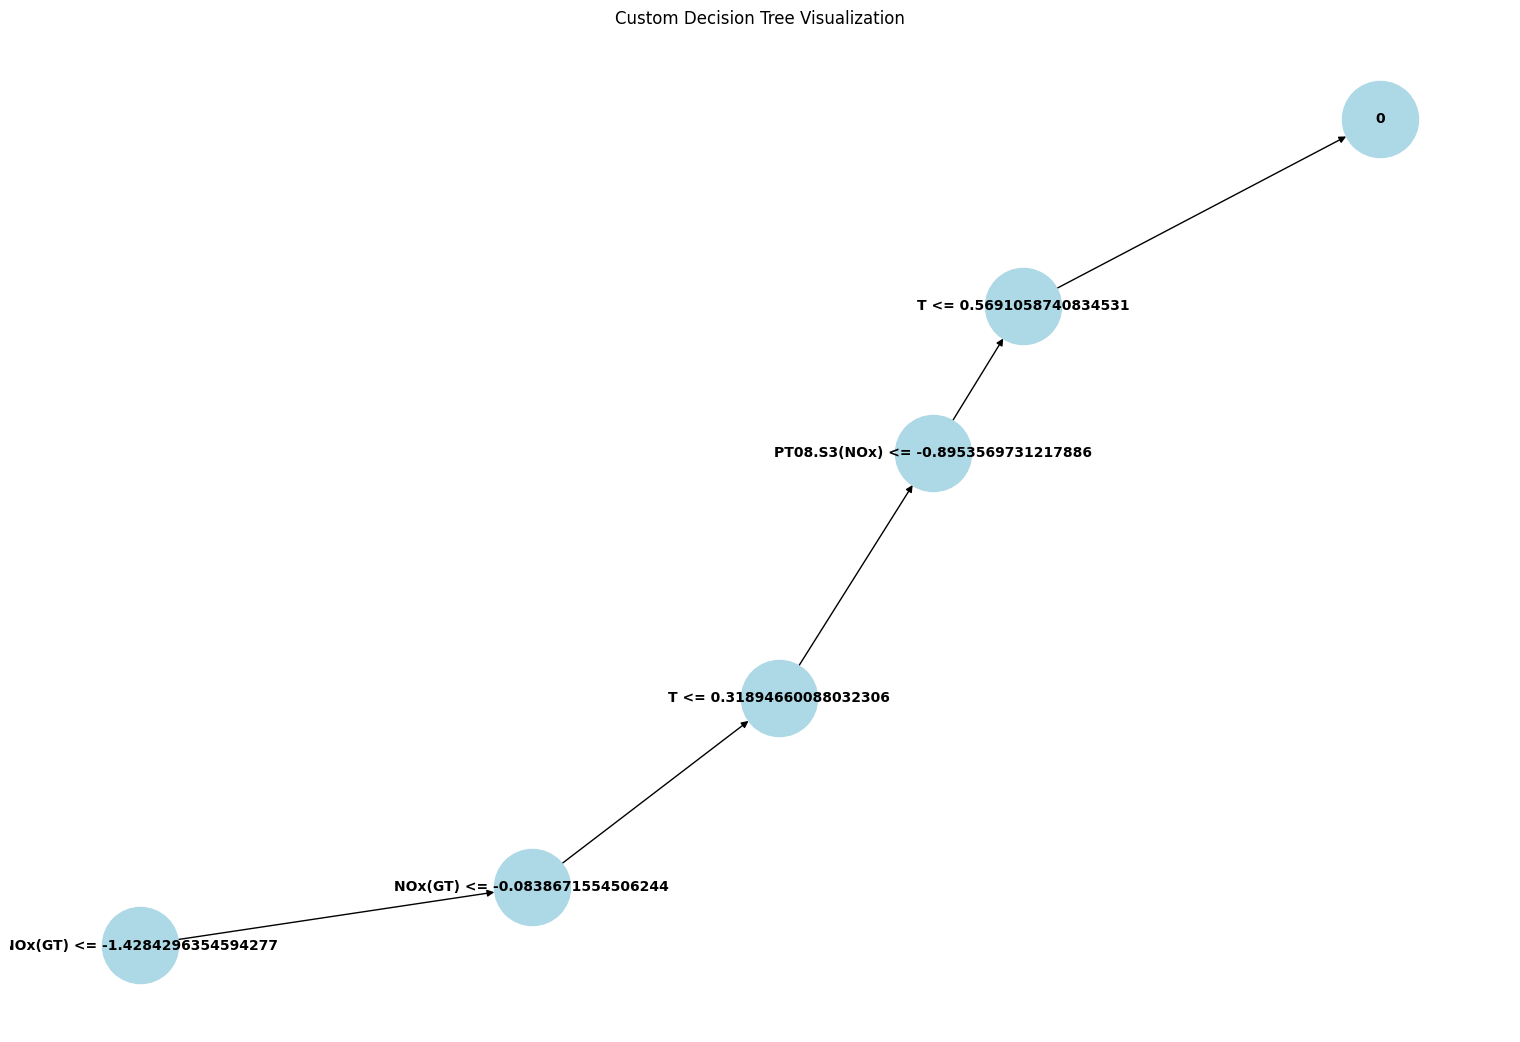

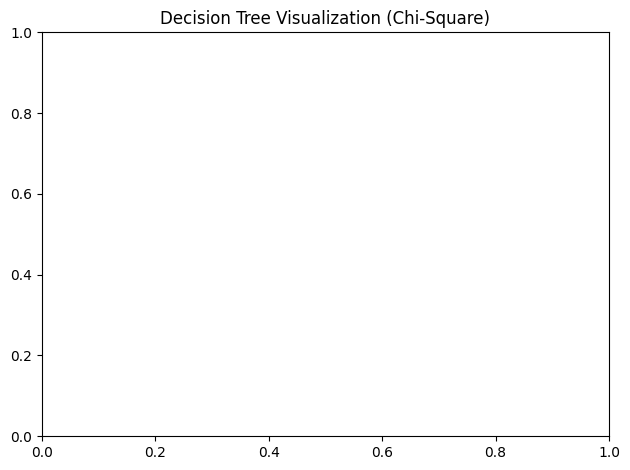

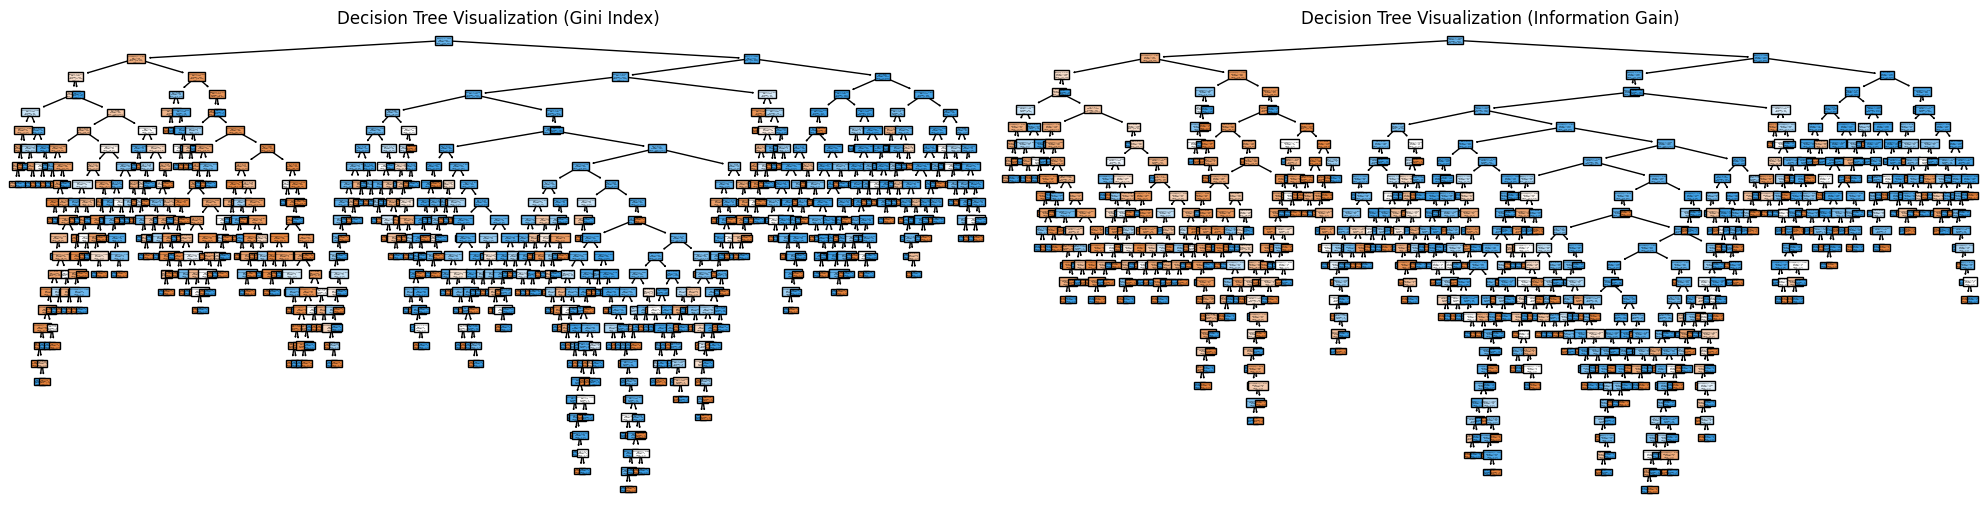

In [55]:
# Plot the custom decision trees for VarianceReductionDecisionTree and ChiSquareDecisionTree
plt.figure(figsize=(20, 10))

# Variance Reduction - Access the tree structure from the model
plt.subplot(2, 2, 3)
plot_tree_custom(models['variance'].tree, X.columns, np.unique(y))  # Use .tree attribute here
plt.title("Decision Tree Visualization (Variance Reduction)")

# Chi-Square - Access the tree structure from the model
plt.subplot(2, 2, 4)
plot_tree_custom(models['chi2'].tree, X.columns, np.unique(y))  # Use .tree attribute here
plt.title("Decision Tree Visualization (Chi-Square)")

plt.tight_layout()
plt.show()

# Visualize Decision Trees for Gini and Entropy (as they are standard Decision Trees)
plt.figure(figsize=(20, 10))

# Gini
plt.subplot(2, 2, 1)
plot_tree(models['gini'],
          feature_names=X.columns,
          class_names=[str(cls) for cls in models['gini'].classes_],  # Convert class labels to strings
          filled=True)
plt.title("Decision Tree Visualization (Gini Index)")

# Entropy (Information Gain)
plt.subplot(2, 2, 2)
plot_tree(models['entropy'],
          feature_names=X.columns,
          class_names=[str(cls) for cls in models['entropy'].classes_],  # Convert class labels to strings
          filled=True)
plt.title("Decision Tree Visualization (Information Gain)")

plt.tight_layout()
plt.show()



# Conclusion

### Summary of Findings:

- **Gini Index**:  
  **Accuracy**: 0.89  
  *Strengths*: Works well for balanced splits, especially in binary classification.  
  *Weaknesses*: Can be biased toward features with more categories and may not perform well if classes aren’t clearly separated.

- **Information Gain (Entropy)**:  
  **Accuracy**: 0.90  
  *Strengths*: Effective for both binary and multi-class problems, reducing uncertainty in the split.  
  *Weaknesses*: Like Gini, it can favor features with many categories and is computationally heavy on large datasets.

- **Chi-Square**:  
  **Accuracy**: 0.17  
  *Strengths*: Useful in testing feature independence, especially for categorical data.  
  *Weaknesses*: Performed poorly here, likely due to the continuous features and the mismatch between the Chi-Square test and the dataset’s nature.

- **Variance Reduction**:  
  **Accuracy**: 0.17  
  *Strengths*: Minimizes variance in regression tasks.  
  *Weaknesses*: Not effective for classification. The model struggled due to overfitting or unsuitable splitting criteria.

### Discussion on Splitting Criteria:

Gini and Entropy are the most effective for classification in this dataset, both performing well with accuracies over 0.89. Their results are comparable, suggesting they’re suitable for tasks where the target is categorical.

Chi-Square and Variance Reduction didn’t work well. Chi-Square failed because it’s better suited for categorical data and independent features, while Variance Reduction is more appropriate for regression tasks.

### Potential Improvements and Future Work:

- **Chi-Square**: Preprocess features for better compatibility with Chi-Square, like discretizing continuous features. Exploring other feature importance methods, such as Mutual Information, could help.
  
- **Variance Reduction**: It’s not ideal for classification problems. Future work could modify the algorithm to handle classification or use more appropriate methods like Gini or Entropy.

- **Feature Engineering**: Applying transformations to numerical features or converting them to categorical ones might help Chi-Square and Variance Reduction.

- **Model Selection**: Exploring more advanced decision tree models like Random Forests or Gradient Boosting could improve performance, especially with complex datasets.

- **Hyperparameter Tuning**: Fine-tuning parameters like max_depth and min_samples_split could improve the performance of all models, particularly the ones with low initial accuracy.